# Описание данных 

**Данные для первой части**


*Файл hypothesis.csv*

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Данные для второй части**


*Файл orders.csv*

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

*Файл visitors.csv*

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста


# Описание проекта 

Аналитики совместно с отделом маркетинга подготовили список гипотез для увеличения выручки. Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.


**Часть 1. Приоритизация гипотез.**

В файле *hypothesis.csv* 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами `Reach`, `Impact`, `Confidence`, `Effort.`

**Задачи**

- Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.

- Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.

- Проанализировать, как изменилась приоритизация гипотез при применении RICE вместо ICE.

**Часть 2. Анализ A/B-теста.**

Был проведен A/B-тест, результаты которого описаны в файлах *orders.csv* и *visitors.csv*

**Задачи** 

Проанализировать A/B-тест:
- График кумулятивной выручки по группам.
- График кумулятивного среднего чека по группам.
- График относительного изменения кумулятивного среднего чека группы B к группе A. 
- График кумулятивной конверсии по группам. 
- График относительного изменения кумулятивной конверсии группы B к группе A. 
- Точечный график количества заказов по пользователям. 
- Подсчет 95-й и 99-й перцентилей количества заказов на пользователя. Граница для определения аномальных пользователей.
- Точечный график стоимостей заказов. 
- Подсчет 95-й и 99-й перцентилей стоимости заказов. Граница для определения аномальных заказов.
- Статистическая значимость различий в конверсии между группами по «сырым» данным. 
- Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным. 
- Статистическая значимость различий в конверсии между группами по «очищенным» данным. 
- Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным. 
- Принять решение по результатам теста: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.


## Загрузка данных, импорт библиотек, предобработка

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pathlib
from pathlib import Path
import seaborn as sns

pd.set_option('display.max_colwidth', None)

In [2]:
hypothesis, orders, visitors = (
    pd.read_csv('/datasets/hypothesis.csv'),    # гипотезы
    pd.read_csv('/datasets/orders.csv'),        # заказы
    pd.read_csv('/datasets/visitors.csv'),      # пользователи
)

### Таблица hypothesis

In [3]:
hypothesis.info() # общая инфо гипотезы

hypothesis.head() # вывод первых строк

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [4]:
hypothesis.columns = hypothesis.columns.str.lower() # приведем к нижнему регистру

print(hypothesis.isna().sum()) # пропуски
hypothesis.duplicated().sum()  # дубликаты


hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64


0

### Таблица orders

In [5]:
orders.info() # общая инфо заказы

orders.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
133,3060563671,2458001652,2019-08-22,5190,A


In [6]:
orders['date'] = pd.to_datetime(orders['date']) # приведем дату в формат datetime

orders = orders.rename(columns={'transactionId': 'transaction_id', # переименуем столбцы
                                'visitorId': 'visitor_id'})

print(orders.isna().sum()) # проверка на пропуски
orders.duplicated().sum()  # проверка дубликатов


transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64


0

### Таблица visitors

In [7]:
visitors.info() # общая инфо

visitors.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
38,2019-08-08,B,654


In [8]:
visitors['date'] = pd.to_datetime(visitors['date']) # меняем формат даты на datetime

print(visitors.isna().sum()) # пропуски
visitors.duplicated().sum()  # дубликаты

date        0
group       0
visitors    0
dtype: int64


0

### Проверка данных для теста

Перед началом А/В теста проведем проверку и убедимся, что:

- количество пользователей в группах различается не более, чем на 1%
- пользователи в группах не пересекаются 

In [9]:
# находим количество пользователей в двух группах и % их соотношения
users = visitors.groupby(['group']).agg({'visitors': 'sum'}).reset_index()

display(users)

print(users.loc[0, 'visitors'] / users.loc[1, 'visitors'] * 100)


,group,visitors
0,A,18736
1,B,18916


99.04842461408332


Число пользователей в группах одинаковое на 99%

In [10]:
# выделим срезы пользователей по группам, посчитаем количество пересекающихся пользователей
group_a = orders.query('group == "A"') 
group_b = orders.query('group == "B"') 

cross_users = list(np.intersect1d(group_a['visitor_id'], group_b['visitor_id']))

print(len(cross_users))

58


In [11]:
# уберем из анализа пересекающихся пользователей
orders = orders.query('visitor_id not in @cross_users')

orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1016 non-null   int64         
 1   visitor_id      1016 non-null   int64         
 2   date            1016 non-null   datetime64[ns]
 3   revenue         1016 non-null   int64         
 4   group           1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


**Вывод**

Таблицы подготовлены к анализу, проверены возможные ошибки. Пропущенных значений и явных дубликатов в данных не обнаружено, формат колонок *date* в таблицах `orders` и `visitors` заменен с object на datetime дальнейшей корректной работы функций. Названия колонок в `hypothesis` и `orders` приведены в соответсвие с общепринятым стилем. 

Количество пользователей в группах А и В отличается не более, чем на 1%, пересекающиеся пользователи удалены из таблицы orders. Данные готовы для дальнейшего анализа 


## Часть 1. Приоритизация гипотез.

### Фреймворк ICE для приоритизации гипотез. 

Считаем по формуле  $$ ICE = {\frac{Impact * Confidence}{Efforts}} $$

In [12]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'] / 
                     hypothesis['efforts']).round(2)

hypothesis.sort_values(by='ICE', ascending=False)


,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


### Фреймворк RICE для приоритизации гипотез. 

Считаем по формуле  $$ RICE = {\frac{Reach * Impact * Confidence}{Efforts}} $$

In [13]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * 
                      hypothesis['confidence'] / hypothesis['efforts']).round(2)

hypothesis.sort_values(by='RICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


In [14]:
# объединим результаты ранжирования в одной таблице
numeric_columns = ['ICE', 'RICE'] 

display(hypothesis[['hypothesis', 'ICE', 'RICE']]
        .sort_values(['RICE', 'ICE'], ascending=[False, False])
        .style.highlight_max(color='red', subset=numeric_columns))

,hypothesis,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,112.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,56.000000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.330000,40.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,40.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.200000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.120000,9.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,4.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.330000,4.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,3.000000


**Вывод**

Приорететность всех гипотез, кроме №4, различается. Фреймворк ICE не учитывает охват пользователей, поэтому при применении RICE самые перспективные гипотезы те, у которых параметр `Reach` максимальный, то есть затрагивают 80% и 100% пользователей.


## Часть 2. Анализ A/B-теста

Для дальнейших расчетов и постороения графиков создадим таблицу с кумулятивными данными о заказах и посетителях на основе таблиц `orders` и `visitors`

In [15]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


In [16]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [17]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date', 'group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
orders_aggregated = dates_groups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# получаем агрегированные кумулятивные по дням данные о посетителях 
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

# объединяем кумулятивные данные в одной таблице 
cumulative_data = orders_aggregated.merge(
    visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group']
)

# присваиваем ее столбцам понятные названия
cumulative_data.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

cumulative_data.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


### График кумулятивной выручки по группам. 

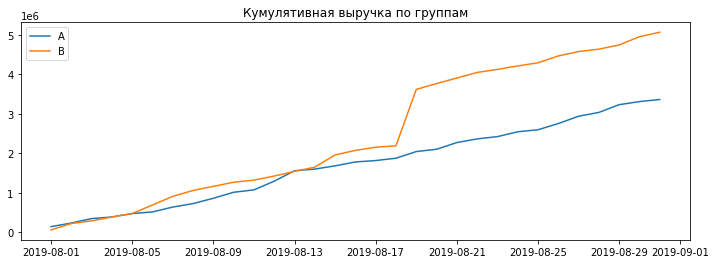

In [18]:

# таблица с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_A = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# таблица с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_B = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

# задаем масштаб графика
plt.figure(figsize=(12,4))

# строим график выручки группы А
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label='A')

# строим график выручки группы B
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label='B')

plt.legend()
plt.title('Кумулятивная выручка по группам')
plt.show()

Выручка более равномерно растет для группы А, группа В демонстрирует резкий скачок примерно в середине теста, что видимо указывает на наличие выбросов - аномально больших заказов или резкое увеличение их количества. В дальнейшем анализе их необходимо будет удалить.

### График кумулятивного среднего чека по группам. 

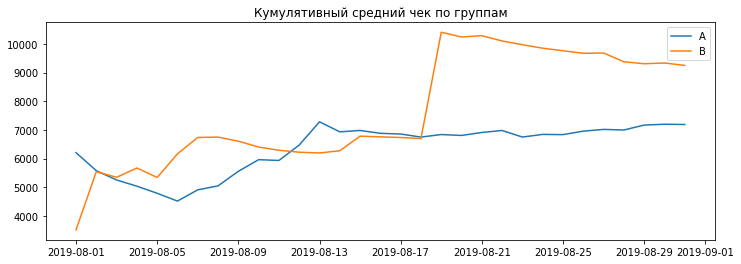

In [19]:
# задаем масштаб графика
plt.figure(figsize=(12,4))

# разделим кумулятивную выручку на кумулятивное число заказов для каждой группы
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue']/cumulative_revenue_A['orders'], label='A')

plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue']/cumulative_revenue_B['orders'], label='B')

plt.legend() 
plt.title('Кумулятивный средний чек по группам')
plt.show()


Средний чек для группы А сначала снижается, затем показывет некоторый рост и в итоге стабилизируется. В группе В скачкообразный рост и снова резкий пик в том же месте, где и на предыдущем графике общей выручки - значит дело в аномальном увеличении среднего чека группы В. После скачка динамика в этой группе отрицательная.

### График относительного изменения кумулятивного среднего чека группы B к группе A. 

In [20]:
cumulative_revenue_A.head()

,date,revenue,orders
0,2019-08-01,142779,23
2,2019-08-02,234381,42
4,2019-08-03,346854,66
6,2019-08-04,388030,77
8,2019-08-05,474413,99


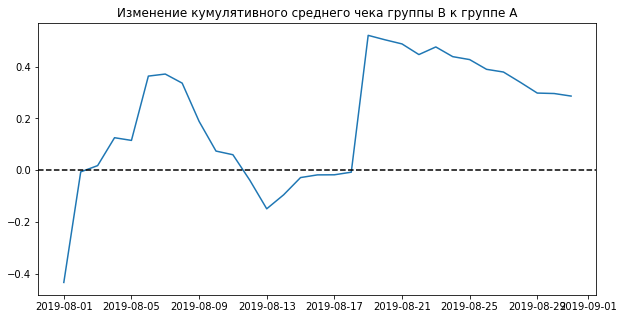

In [21]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_A.merge(
    cumulative_revenue_B, left_on='date', right_on='date', 
    how='left', suffixes=['A', 'B']
)

# задаем масштаб графика
plt.figure(figsize=(10,5))

# cтроим отношение средних чеков
plt.plot(merged_cumulative_revenue['date'], (
    merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB']
)
         /(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)

# добавляем горизонтальную ось 
plt.axhline(y=0, color='black', linestyle='--')

plt.title('Изменение кумулятивного среднего чека группы B к группе A')
plt.show()

И снова этот характерный скачок в том же моменте теста. Кроме того, и в некоторых других точках график различия между группами резко меняется, что определенно указывает, в какие даты были совершены аномально крупные заказы.

### График кумулятивной конверсии по группам. 

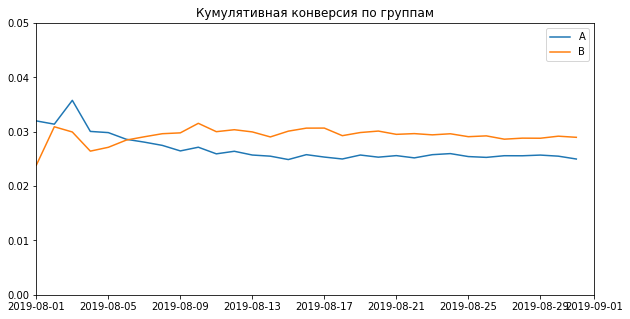

In [22]:
# считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulative_data_A = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_B = cumulative_data[cumulative_data['group']=='B']

# задаем масштаб графика
plt.figure(figsize=(10,5))

# строим графики
plt.plot(cumulative_data_A['date'], cumulative_data_A['conversion'], label='A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['conversion'], label='B')

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.05])

plt.legend()
plt.title('Кумулятивная конверсия по группам')
plt.show()

И в группе А, и в группе В есть небольшой пик в начале теста, далее конверсия группы А проседает, а в группе В почти симметрично подрастает, затем оба сегмента стабилизируются. В целом колебания конверсии  относительно небольшие. Группа А в конце теста фиксируется на значении около 3%, группа В - около 3,5%

### График относительного изменения кумулятивной конверсии группы B к группе A. 

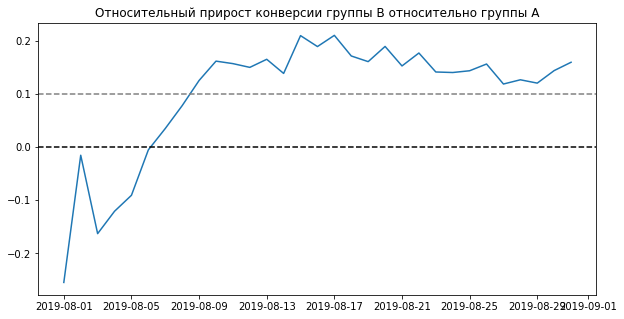

In [23]:
# объединим таблицы с конверсиями
merged_cumulative_conversions = cumulative_data_A[['date','conversion']].merge(
    cumulative_data_B[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# задаем масштаб графика
plt.figure(figsize=(10,5))

# стороим графики
plt.plot(merged_cumulative_conversions['date'], 
         merged_cumulative_conversions['conversionB'] / merged_cumulative_conversions['conversionA']-1)
plt.title('Относительный прирост конверсии группы B относительно группы A')

# добавляем горизонтальные оси
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.10, color='grey', linestyle='--')
plt.show()


Если не учитывать падение в начале, то в целом конверсия группы В значительно опережает конверсию группы А, в середине теста доходит до разницы в 20% и к концу колеблется в районе 15%. Но мы помним про возможные аномальные значения среднего чека в группе В, поэтому их нужно проанализировать и выяснить, насколько они искажают картину.




### График количества заказов по пользователям. 

In [24]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


In [25]:
# найдем число заказов по пользователям 
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)


orders_by_users.sort_values(by='transaction_id', ascending=False).head()

,visitor_id,transaction_id
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3


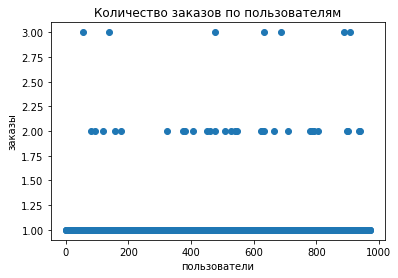

In [26]:
x_values = pd.Series(range(0, len(orders_by_users)))

plt.scatter(x_values, orders_by_users['transaction_id']) 
plt.title('Количество заказов по пользователям')
plt.ylabel('заказы')
plt.xlabel('пользователи')
plt.show()

В основном пользователи совершают 1 заказ, гораздо реже - 2, но также есть незначительное количество тех, кто сделал 3 заказа(и это определенно выбросы) А вот являются ли пользователи с двумя заказами аномальными, посмотрим с помощью выборочных перцентилев.

### Подсчет 95-й и 99-й перцентилей количества заказов на пользователя. 

In [27]:
print('Количество заказов у 95% покупателей не более {}'
      .format(np.percentile(orders_by_users['transaction_id'], 95)))

print('Количество заказов у 99% покупателей не более {}'
      .format(np.percentile(orders_by_users['transaction_id'], 99)))

Количество заказов у 95% покупателей не более 1.0
Количество заказов у 99% покупателей не более 2.0


Около 5% пользователей совершают больше, чем один заказ и всего 1% делают 2 или 3. Поэтому возьмем максимальную планку в 2 заказа, чтобы отсеять аномальных покупателей. 

### График стоимостей заказов.


,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
743,3603576309,4133034833,2019-08-09,67990,A


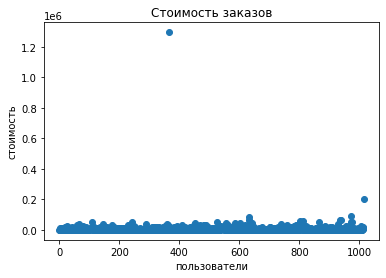

In [28]:
# отсортируем таблицу заказов, начиная с самых крупных
display(orders.sort_values(by='revenue', ascending=False).head())

x_values = pd.Series(range(0, len(orders['revenue'])))

plt.scatter(x_values, orders['revenue'])
plt.title('Стоимость заказов')
plt.ylabel('стоимость')
plt.xlabel('пользователи')
plt.show()

Есть два заметно дорогих заказа - на 1 294 500 и 202 740. Очевидно именно этот заказ, превышающий миллион, искажал куммулятивный чек в группе B и вызывал резкий скачок на графиках выручки и среднего чека. Определим с помощью выборочных перцентилев границу аномальных заказов.

### Подсчет 95-й и 99-й перцентилей стоимости заказов. 

In [29]:
print('Стоимость заказа у 95% покупателей не превышает {}'
      .format(np.percentile(orders['revenue'], 95).round()))

print('Стоимость заказа у 99% покупателей не превышает {}'
      .format(np.percentile(orders['revenue'], 99).round()))

Стоимость заказа у 95% покупателей не превышает 26785.0
Стоимость заказа у 99% покупателей не превышает 53904.0


Не более 5% заказов дороже 26 785 и не более 1% дороже 53 904. Также как и в случае с количеством заказов, отсеем 1% пользователей с аномально дорогими заказами.

### Статистическая значимость различий в конверсии между группами по «сырым» данным. 

In [30]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [31]:
# собираем кумулятивное количество пользователей в выбранную дату в группе A

visitors_A_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_A_daily.columns = ['date', 'visitors_per_date_A']


visitors_A_cummulative = visitors_A_daily.apply(
    lambda x: visitors_A_daily[visitors_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_A': 'sum'}
    ),
    axis=1,
)

visitors_A_cummulative.columns = ['date', 'visitors_cummulative_A']

visitors_A_cummulative.head()

,date,visitors_cummulative_A
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


In [32]:
# собираем кумулятивное количество пользователей в выбранную дату в группе B

visitors_B_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_B_daily.columns = ['date', 'visitors_per_date_B']

visitors_B_cummulative = visitors_B_daily.apply(
    lambda x: visitors_B_daily[visitors_B_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_B': 'sum'}
    ),
    axis=1,
)
visitors_B_cummulative.columns = ['date', 'visitors_cummulative_B']

visitors_B_cummulative.head()

,date,visitors_cummulative_B
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


In [33]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


In [34]:
# собираем данные с количеством заказов в выбранную дату в группе A

orders_A_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_A_daily.columns = ['date', 'orders_per_date_A', 'revenue_per_date_A']



In [35]:
# собираем данные с количеством заказов в выбранную дату в группе B

orders_B_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_B_daily.columns = ['date', 'orders_per_date_B', 'revenue_per_date_B']


In [36]:
# переименуем столбцы таблицы с куммулятивными данными количества и суммы заказов ранее созданной таблицы

merged_cumulative_revenue.columns = ['date', 
                                     'revenue_cummulative_A', 
                                     'orders_cummulative_A',
                                     'revenue_cummulative_B',
                                     'orders_cummulative_B']

merged_cumulative_revenue.head()

,date,revenue_cummulative_A,orders_cummulative_A,revenue_cummulative_B,orders_cummulative_B
0,2019-08-01,142779,23,59758,17
1,2019-08-02,234381,42,221801,40
2,2019-08-03,346854,66,288850,54
3,2019-08-04,388030,77,385740,68
4,2019-08-05,474413,99,475648,89


In [37]:
# соединяем все таблицы в одну

data = (
    orders_A_daily.merge(
        orders_B_daily, left_on='date', right_on='date', how='left'
    )
    .merge(merged_cumulative_revenue, left_on='date', right_on='date', how='left') 
    .merge(visitors_A_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_B_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_A_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_B_cummulative, left_on='date', right_on='date', how='left')
)

display(data.head())

,date,orders_per_date_A,revenue_per_date_A,orders_per_date_B,revenue_per_date_B,revenue_cummulative_A,orders_cummulative_A,revenue_cummulative_B,orders_cummulative_B,visitors_per_date_A,visitors_per_date_B,visitors_cummulative_A,visitors_cummulative_B
0,2019-08-01,23,142779,17,59758,142779,23,59758,17,719,713,719,713
1,2019-08-02,19,91602,23,162043,234381,42,221801,40,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,346854,66,288850,54,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,388030,77,385740,68,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,474413,99,475648,89,756,707,3318,3280


In [38]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


In [39]:
# Создадим переменные с числом совершенных заказов для пользователей, которые заказывали хотя бы 1 раз

orders_by_users_A = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_A.columns = ['user_id', 'orders']

orders_by_users_B = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_B.columns = ['user_id', 'orders']

# объявим переменные, в которых пользователям из разных групп будет соответствовать количество заказов

sample_A = pd.concat([orders_by_users_A['orders'],pd.Series
                      (0, index=np.arange(data['visitors_per_date_A'].sum() - len(orders_by_users_A['orders'])), name='orders')],axis=0)

sample_B = pd.concat([orders_by_users_B['orders'],pd.Series
                      (0, index=np.arange(data['visitors_per_date_B'].sum() - len(orders_by_users_B['orders'])), name='orders')],axis=0)


Сформулируем гипотезы, возьмем для проверки тест Манна-Уитни

**H0: конверсия в группах А и В равна**

**H1: конверсия в группах А и В не равна**

In [40]:
alpha = 0.05

results = stats.mannwhitneyu(sample_A, sample_B)

pvalue = results.pvalue

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение: 0.011018084110014696
Отвергаем нулевую гипотезу


In [41]:
print('Относительный прирост конверсии группы B {0:.3f}'
      .format(sample_B.mean() / sample_A.mean() - 1))

Относительный прирост конверсии группы B 0.160


**Вывод**

Анализ сырых данных показывает, что в конверсии между группами есть статистические различия, конверсия группы В выше на 16%

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным. 

Сформулируем гипотезы, возьмем для проверки тест Манна-Уитни

**Н0: различий в среднем чеке между группами А и В нет.**

**Н1:  различия в среднем чеке между группами А и В есть.**

In [42]:
alpha = 0.05

results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                             orders[orders['group']=='B']['revenue'])

pvalue = results.pvalue

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.8294908998149533
Не получилось отвергнуть нулевую гипотезу


In [43]:
print('Относительная разница в среднем чеке между группами {0:.3f}'
      .format(orders[orders['group']=='B']['revenue']
              .mean()/orders[orders['group']=='A']['revenue'].mean()-1))

Относительная разница в среднем чеке между группами 0.287


**Вывод**

Статистических различий в среднем чеке нет. При этом средний чек группы B значительно, на 28% превышает показатель в группе A. Необходимо убрать из анализа пользователей с аномально крупными заказами и пользователей с количеством заказов выше заданной ранее планки, чтобы очистить данные и сравнить, насколько выбросы влияют на конверсию и средний чек в группах 

### Статистическая значимость различий в конверсии между группами по «очищенным» данным. 

In [44]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


Учитывая предыдущие выводы, уберем из анализа пользователей с 3 заказами, и пользователей, сделавших заказы дороже 54 000

In [45]:
# определяем слишком большое количество заказов 
many_orders = pd.concat(
    [
        orders_by_users_A[orders_by_users_A['orders'] > 2]['user_id'],
        orders_by_users_B[orders_by_users_B['orders'] > 2]['user_id'],
    ],
    axis=0,
)

# определяем слишком дорогие заказы
expensive_orders = orders[orders['revenue'] > 54000]['visitor_id']

# отфильтровываем аномальных пользователей
abnormal_users = (
    pd.concat([many_orders, expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

abnormal_users.count()

16

In [46]:

# переменные с очищенным количеством заказов по пользователям по группам
sample_A_filtered = pd.concat(
    [
        orders_by_users_A[
            np.logical_not(orders_by_users_A['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_A'].sum() - len(orders_by_users_A['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_B_filtered = pd.concat(
    [
        orders_by_users_B[
            np.logical_not(orders_by_users_B['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_B'].sum() - len(orders_by_users_B['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Сформулируем гипотезы для очищенных данных 

**H0: конверсия в группах А и В равна**

**H1: конверсия в группах А и В не равна**

In [47]:
# применим статистический критерий Манна-Уитни к полученным выборкам
alpha = 0.05

results = stats.mannwhitneyu(sample_A_filtered, sample_B_filtered)

pvalue = results.pvalue

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение: 0.007021302207652193
Отвергаем нулевую гипотезу


In [48]:
print('Относительный прирост конверсии группы B {0:.3f}'
      .format(sample_B_filtered.mean() / sample_A_filtered.mean() - 1))

Относительный прирост конверсии группы B 0.189


**Вывод** 

После фильтрации результаты по конверсии изменились, но не кардинально. Статистическое различие между группами по-прежнему есть, конверсия группы В превышает конверсию группы А на 18.9% против 16% в сырых данных.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

In [49]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


Сформулируем гипотезы для отфильтрованных данных

**Н0: различий в среднем чеке между группами А и В нет.**

**Н1:  различия в среднем чеке между группами А и В есть.**

In [50]:
alpha = 0.05

results = stats.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[np.logical_and(orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'])
                             
pvalue = results.pvalue

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.7877044862440841
Не получилось отвергнуть нулевую гипотезу


In [51]:
print('Относительная разница в среднем чеке между группами{0:.3f}'
      .format(orders[np.logical_and(orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[np.logical_and(orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

Относительная разница в среднем чеке между группами-0.032


**Вывод** 

P-value изменился незначительно, в очищенных данных также нет статитстической разницы между средним чеком в разных группах. Различие между группами сократилось с 28% до 0.3% и не в пользу лидирующей прежде по этому показателю группы В. Выбросы действительно сильно искажали данные в этом сегменте.

### Результаты теста

- Конверсия в группах статистически различается и в сырых данных, и в отфильтрованных.

- По среднему чеку нет статистически значимого различия между группами ни по «сырым», ни по отфильтрованным данным. 

- После удаления аномалий группа В не показывает преимущества по сумме среднего чека перед группой А

- График различия среднего чека колеблется из-за аномальных значений. Сделать из этого графика определённые выводы нельзя.

- График отностительной конверсии в группе В демонстрирует рост по отношению к группе А примерно на 15% в конце теста и еще не зафиксировался около среднего значения

**Вывод**

Продолжаем тестирование, пока колебания конверсии в группе В не стабилизируются окончательно 